# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [113]:
#!pip install sklearn-crfsuite
import pandas as pd
import numpy as np
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import matplotlib.pyplot as plt
import seaborn as sns

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

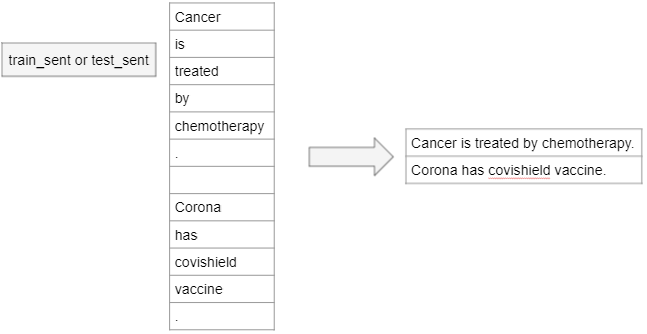

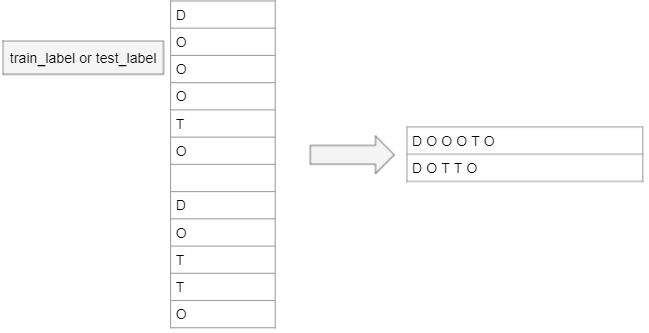

## Task 1
### Data Preprocessing
#### Goal: Convert the tokenized data (words separated by newlines with blank lines marking sentence boundaries) into sentence strings (or lists of tokens) for both the text and the labels.

#### Steps:
* Read the file: Read your train and test files.
* Group tokens into sentences: Whenever you encounter a blank line (or a newline that signals the end of a sentence), start a new sentence.
* Do the same for labels: Build sentences for the labels

In [115]:
def read_data(file_path):
    """
    Reads a file where each token is on a separate line and sentences are separated by blank lines.
    Returns a list of sentences, where each sentence is a list of tokens.
    """
    sentences = []
    sentence = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:  # not a blank line
                sentence.append(line)
            else:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
        # if file does not end with a blank line, add the last sentence
        if sentence:
            sentences.append(sentence)
    return sentences

# Example usage:
train_tokens = read_data("train_sent")
train_labels = read_data("train_label")
test_tokens  = read_data("test_sent")
test_labels  = read_data("test_label")

# Print a few sentences and labels for verification
for i in range(5):
    print("Sentence {}: {}".format(i, train_tokens[i]))
    print("Labels {}: {}\n".format(i, train_labels[i]))

print("Total sentences in train:", len(train_tokens))
print("Total sentences in test:", len(test_tokens))


Sentence 0: ['All', 'live', 'births', '>', 'or', '=', '23', 'weeks', 'at', 'the', 'University', 'of', 'Vermont', 'in', '1995', '(', 'n', '=', '2395', ')', 'were', 'retrospectively', 'analyzed', 'for', 'delivery', 'route', ',', 'indication', 'for', 'cesarean', ',', 'gestational', 'age', ',', 'parity', ',', 'and', 'practice', 'group', '(', 'to', 'reflect', 'risk', 'status', ')']
Labels 0: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence 1: ['The', 'total', 'cesarean', 'rate', 'was', '14.4', '%', '(', '344', 'of', '2395', ')', ',', 'and', 'the', 'primary', 'rate', 'was', '11.4', '%', '(', '244', 'of', '2144', ')']
Labels 1: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence 2: ['Abnormal', 'presentation', 'was', 'the', 'm

In [180]:
print("the length of train labels "+ str(len(train_labels)))
print("the length of test labels "+ str(len(test_labels)))


the length of train labels 2599
the length of test labels 1056


### Total sentences in train and test is matching with train and test labels

## Task 2
### Concept Identification Using PoS Tagging
#### Goal: Identify the most common concepts (words with PoS tags NOUN or PROPN) from the combined train and test datasets.

#### Steps:
* Use spaCy’s English model to tag each token.
* Count frequencies of tokens that are nouns (NOUN) or proper nouns (PROPN).
* Output the top 25 most frequent tokens.

In [118]:
import spacy
from collections import Counter

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

def extract_nouns(sentences):
    """Extract tokens with POS tags NOUN or PROPN from a list of sentences."""
    noun_counter = Counter()
    for sent in sentences:
        # join tokens to form sentence text (or process tokens individually)
        sent_text = " ".join(sent)
        doc = nlp(sent_text)
        for token in doc:
            if token.pos_ in ["NOUN", "PROPN"]:
                noun_counter[token.text.lower()] += 1
    return noun_counter

# Combine train and test sentences
all_sentences = train_tokens + test_tokens

noun_counts = extract_nouns(all_sentences)
top_25 = noun_counts.most_common(25)
print("Top 25 concepts (NOUN/PROPN):")
for word, count in top_25:
    print(f"{word}: {count}")


Top 25 concepts (NOUN/PROPN):
patients: 507
treatment: 304
%: 247
cancer: 211
therapy: 177
study: 174
disease: 149
cell: 142
lung: 118
results: 116
group: 111
effects: 99
gene: 91
chemotherapy: 91
use: 87
effect: 82
women: 81
analysis: 76
risk: 74
surgery: 73
cases: 72
p: 72
rate: 68
survival: 67
response: 66


## Task 3
### Defining Features for CRF
#### Goal: For each token in a sentence, define features that will help the CRF model label the token correctly.

#### Common Features to Include:
* The current token (word).
* Lowercase form of the token.
* Suffixes/prefixes.
* Is the token capitalized, is it numeric, etc.
* PoS tag of the current token.
* Context: The previous token’s features (and you may also include the next token’s features for extra context).
* Special flags for beginning or end of a sentence.

In [120]:
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]
    features = [
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.isdigit=%s' % word.isdigit(),
        'word.startsWithCapital=%s' % word[0].isupper(),
    ]

    # Use the previous word also while defining features
    if pos > 0:
        prev_word = sentence[pos - 1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        ])
    else:
        features.append('BEG')  # mark beginning of sentence

    if pos == len(sentence) - 1:
        features.append('END')  # mark end of sentence

    return features


## Task 4 
### Getting the Features and the Labels for Sentences
#### Goal: Convert your entire dataset (both train and test) into lists of feature dictionaries and label sequences.

##### Write a code/function to get the labels of a sentence

In [ ]:
def sentence2features(sentence):
    return [getFeaturesForOneWord(sentence, i) for i in range(len(sentence))]

##### Define the features' values for each sentence as input variable for CRF model in test and the train dataset

In [136]:
X_train = [sentence2features(sent) for sent in train_tokens]
X_test  = [sentence2features(sent) for sent in test_tokens]

##### Define the labels as the target variable for test and the train dataset

In [138]:
# Then build your training and test feature sets
y_train = train_labels
y_test  = test_labels



## Task 5 
### Defining Input and Target Variables
#### At this point, the input variables are X_train and X_test (the features for each token in every sentence) and the target variables are y_train and y_test (the corresponding labels).

Label Counts:
O    39683
D     3439
T     2780
Name: count, dtype: int64


C:\Users\chand\AppData\Local\Temp\ipykernel_26212\1652382473.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


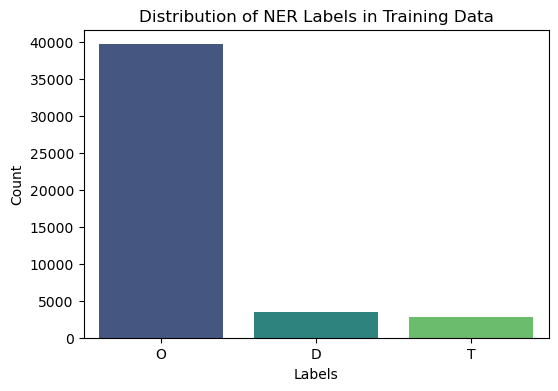

In [145]:

all_labels = [label for sent in y_train for label in sent]
label_series = pd.Series(all_labels)

# Count label frequencies
label_counts = label_series.value_counts()
print("Label Counts:")
print(label_counts)

# Plot the distribution using a bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of NER Labels in Training Data")
plt.show()


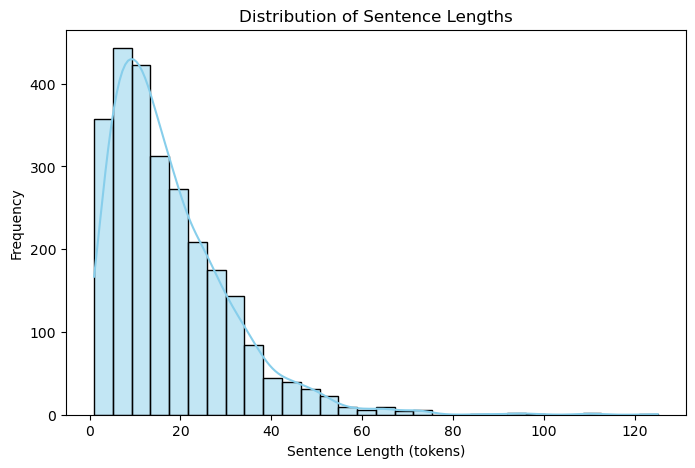

In [147]:
# Calculate sentence lengths for training tokens (each sentence is a list of tokens)
sentence_lengths = [len(sent) for sent in train_tokens]

plt.figure(figsize=(8,5))
sns.histplot(sentence_lengths, bins=30, kde=True, color='skyblue')
plt.xlabel("Sentence Length (tokens)")
plt.ylabel("Frequency")
plt.title("Distribution of Sentence Lengths")
plt.show()


C:\Users\chand\AppData\Local\Temp\ipykernel_26212\3502801525.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=noun_df, x="Count", y="Token", palette="magma")


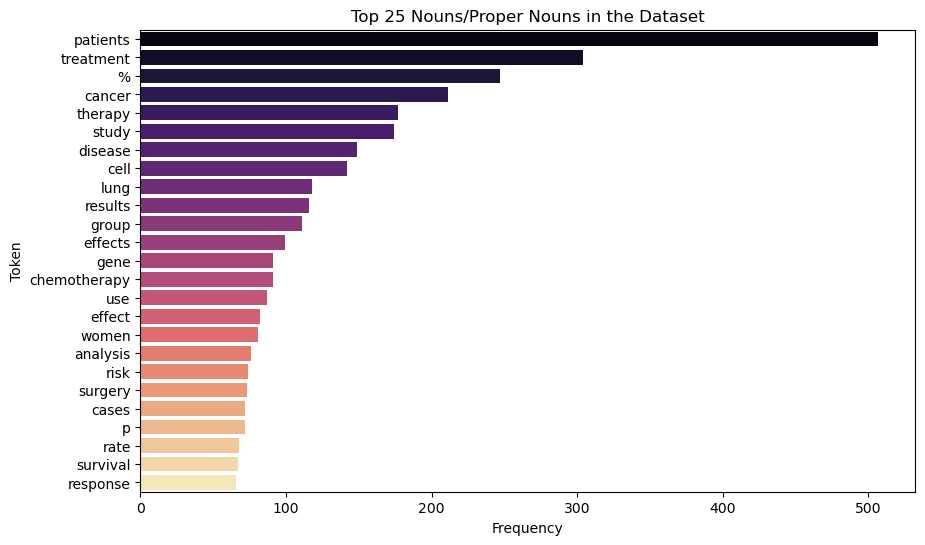

In [149]:
import spacy
from collections import Counter

# Load spaCy’s small English model
nlp = spacy.load("en_core_web_sm")

def extract_noun_tokens(sentences):
    noun_counter = Counter()
    for sent in sentences:
        # join tokens to form a complete sentence
        sent_text = " ".join(sent)
        doc = nlp(sent_text)
        for token in doc:
            if token.pos_ in ["NOUN", "PROPN"]:
                noun_counter[token.text.lower()] += 1
    return noun_counter

# Combine train and test tokens for a more complete analysis
all_sentences = train_tokens + test_tokens
noun_counts = extract_noun_tokens(all_sentences)

# Get the top 25 nouns
top_nouns = noun_counts.most_common(25)
noun_df = pd.DataFrame(top_nouns, columns=["Token", "Count"])

plt.figure(figsize=(10,6))
sns.barplot(data=noun_df, x="Count", y="Token", palette="magma")
plt.title("Top 25 Nouns/Proper Nouns in the Dataset")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()


## Task 6
### Building the CRF Model
#### Goal: Train a CRF model using the features and target labels.

#### Steps:
* Use sklearn_crfsuite.CRF to define the model.
* Set appropriate hyperparameters (e.g., algorithm, regularization parameters).
* Train the model on the training dataset.

In [151]:
# Build the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Define and train the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',  # Limited-memory BFGS
    c1=0.1,             # coefficient for L1 penalty
    c2=0.1,             # coefficient for L2 penalty
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model
crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

## Task 7 
### Evaluating the Model
#### Goal: Use the CRF model to predict the labels for the test set and calculate evaluation metrics (such as the F1 score).

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [154]:
# Predict the labels on the test set
y_pred = crf.predict(X_test)

# Evaluate the model
labels = list(crf.classes_)
# Optionally, remove 'O' from evaluation if desired
# if 'O' in labels:
#     labels.remove('O')

# Calculate the F1 score using the CRF metrics helper
f1_score = metrics.flat_f1_score(y_test, y_pred,
                                 average='weighted', labels=labels)
print("Weighted F1 score: {:.4f}".format(f1_score))

# You can also print the classification report
report = metrics.flat_classification_report(y_test, y_pred, labels=labels)
print(report)


Weighted F1 score: 0.9167
              precision    recall  f1-score   support

           O       0.94      0.97      0.96     16127
           D       0.80      0.63      0.70      1450
           T       0.72      0.52      0.60      1041

    accuracy                           0.92     18618
   macro avg       0.82      0.71      0.75     18618
weighted avg       0.92      0.92      0.92     18618



### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

### Weighted F1 score: 0.9167

## Task 8
### Identifying Diseases and Their Predicted Treatments Using a Custom NER
#### Goal: Create a dictionary where each disease (tokens labeled D) is mapped to its treatment(s) (tokens labeled T) based on the assumption that if a sentence contains a disease, then any treatment mentioned in the same sentence is the treatment for that disease.

#### Steps:
* Iterate through the test sentences.
* For each sentence, find all tokens (or groups of tokens) with the label D and T.
* Build a dictionary such that the key is the disease name (a string formed from one or more tokens with label D) and the value is a list of treatment names.

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

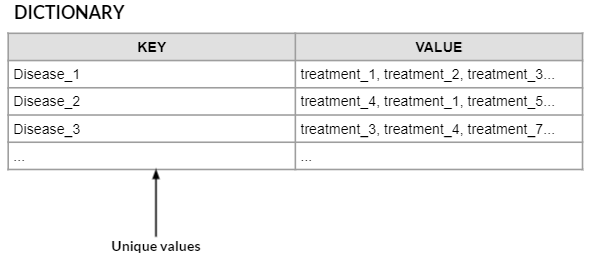

In [160]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Assume test_tokens is a list of token lists for test sentences
# and y_pred is the list of predicted label sequences.
# (If test_tokens is tokenized, do not re-split; use the tokens directly.)

# Initialize an empty DataFrame to store disease-treatment mappings
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(y_pred)):
    labels = y_pred[i]
    tokens = test_tokens[i]
    disease_str = ""
    treatment_str = ""
    
    # Check if both disease and treatment labels are present in the sentence predictions
    if "D" in labels and "T" in labels:
        for j in range(len(labels)):
            if labels[j] == 'D':
                disease_str += tokens[j] + " "
            elif labels[j] == 'T':
                treatment_str += tokens[j] + " "
        disease_str = disease_str.strip()
        treatment_str = treatment_str.strip()

        # Update or add the entry in the DataFrame
        if not D_n_T_DF.empty and (D_n_T_DF['Disease'] == disease_str).any():
            idx = D_n_T_DF.index[D_n_T_DF['Disease'] == disease_str][0]
            current_treatments = D_n_T_DF.at[idx, "Treatments"]
            if isinstance(current_treatments, list):
                if treatment_str not in current_treatments:
                    current_treatments.append(treatment_str)
            else:
                if current_treatments != treatment_str:
                    current_treatments = [current_treatments, treatment_str]
            D_n_T_DF.at[idx, "Treatments"] = current_treatments
        else:
            new_row = pd.DataFrame([[disease_str, treatment_str]], columns=["Disease", "Treatments"])
            D_n_T_DF = pd.concat([D_n_T_DF, new_row], ignore_index=True)

# --- 2. Display the DataFrame in a Nicely Formatted Table ---
print("Disease to Treatment Mapping (Formatted):")
print(tabulate(D_n_T_DF, headers='keys', tablefmt='psql', showindex=False))

# Alternatively, you can also use Pandas' built-in formatting:
print("\nUsing Pandas' to_string:")
print(D_n_T_DF.to_string(index=False))


Disease to Treatment Mapping (Formatted):
+-----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+
| Disease                                                                           | Treatments                                                                                                                                |
|-----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------|
| macrosomic infants in gestational diabetes cases                                  | good glycemic control                                                                                                                     |
| nonimmune hydrops fetalis                           

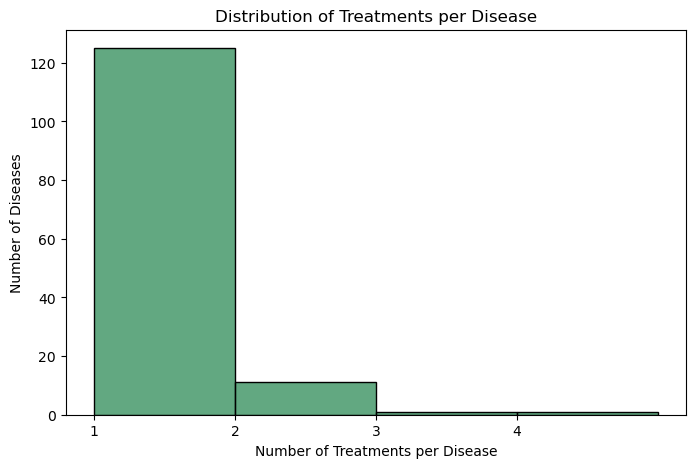

In [161]:
# Assume D_n_T_DF is your disease-to-treatment mapping DataFrame
# We can create a new column for the number of treatments per disease.
D_n_T_DF["Num_Treatments"] = D_n_T_DF["Treatments"].apply(lambda x: len(x) if isinstance(x, list) else 1)

plt.figure(figsize=(8,5))
sns.histplot(D_n_T_DF["Num_Treatments"], bins=range(1, D_n_T_DF["Num_Treatments"].max()+2),
             kde=False, color='seagreen')
plt.xlabel("Number of Treatments per Disease")
plt.ylabel("Number of Diseases")
plt.title("Distribution of Treatments per Disease")
plt.xticks(range(1, D_n_T_DF["Num_Treatments"].max()+1))
plt.show()


### Predicting Treatment for a Specific Disease
##### For example, if you want to predict the treatment for 'hereditary retinoblastoma', simply query your dictionary:

In [163]:
def get_treatment_for_disease(query_disease, mapping_df):
    query_disease_lower = query_disease.lower()
    for idx, row in mapping_df.iterrows():
        mapped_disease_lower = row['Disease'].lower()
        # Allow a loose match: either query is in the mapped disease or vice versa.
        if query_disease_lower in mapped_disease_lower or mapped_disease_lower in query_disease_lower:
            return row['Treatments']
    return None

query = "hereditary retinoblastoma"
treatment = get_treatment_for_disease(query, D_n_T_DF)
if treatment:
    print(f"Predicted treatment(s) for '{query}' is {treatment}")
else:
    print(f"No treatment found for disease '{query}'")


Predicted treatment(s) for 'hereditary retinoblastoma' is radiotherapy


### Keeping initailly built at earlier stages just for reference

In [88]:
def token2features(sent, i):
    """
    Extract features for token at index i in the sentence.
    `sent` is a list of tokens.
    """
    token = sent[i]
    # Process token using spaCy to get PoS
    doc = nlp(token)
    token_obj = list(doc)[0]  # since token is a single word
    features = {
        'bias': 1.0,
        'token': token,
        'token.lower()': token.lower(),
        'token[-3:]': token[-3:],
        'token[-2:]': token[-2:],
        'is_upper': token.isupper(),
        'is_title': token.istitle(),
        'is_digit': token.isdigit(),
        'pos': token_obj.pos_
    }
    
    if i > 0:
        prev_token = sent[i-1]
        doc_prev = nlp(prev_token)
        prev_obj = list(doc_prev)[0]
        features.update({
            '-1:token': prev_token,
            '-1:token.lower()': prev_token.lower(),
            '-1:is_title': prev_token.istitle(),
            '-1:is_upper': prev_token.isupper(),
            '-1:pos': prev_obj.pos_
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        next_token = sent[i+1]
        doc_next = nlp(next_token)
        next_obj = list(doc_next)[0]
        features.update({
            '+1:token': next_token,
            '+1:token.lower()': next_token.lower(),
            '+1:is_title': next_token.istitle(),
            '+1:is_upper': next_token.isupper(),
            '+1:pos': next_obj.pos_
        })
    else:
        features['EOS'] = True  # End of sentence

    return features




In [89]:
# Write a code to get features for a sentence.
X_train = [sentence2features(s) for s in train_tokens]
y_train = [sentence2labels(s) for s in train_labels]

# Process test dataset
X_test = [sentence2features(s) for s in test_tokens]
y_test = [sentence2labels(s) for s in test_labels]


In [90]:
def sentence2features(sent):
    return [token2features(sent, i) for i in range(len(sent))]

def sentence2labels(label_seq):
    # Here label_seq is a list of labels corresponding to each token.
    return label_seq

# Example:
print("Features for first token of first sentence:", sentence2features(train_tokens[0])[0])

Features for first token of first sentence: {'bias': 1.0, 'token': 'All', 'token.lower()': 'all', 'token[-3:]': 'All', 'token[-2:]': 'll', 'is_upper': False, 'is_title': True, 'is_digit': False, 'pos': 'ADV', 'BOS': True, '+1:token': 'live', '+1:token.lower()': 'live', '+1:is_title': False, '+1:is_upper': False, '+1:pos': 'ADJ'}


In [104]:
# Build the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Define and train the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',  # Limited-memory BFGS
    c1=0.1,             # coefficient for L1 penalty
    c2=0.1,             # coefficient for L2 penalty
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model
crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [106]:
# Predict the labels on the test set
y_pred = crf.predict(X_test)

# Evaluate the model
labels = list(crf.classes_)
# Optionally, remove 'O' from evaluation if desired
# if 'O' in labels:
#     labels.remove('O')

# Calculate the F1 score using the CRF metrics helper
f1_score = metrics.flat_f1_score(y_test, y_pred,
                                 average='weighted', labels=labels)
print("Weighted F1 score: {:.4f}".format(f1_score))

# You can also print the classification report
report = metrics.flat_classification_report(y_test, y_pred, labels=labels)
print(report)


Weighted F1 score: 0.9167
              precision    recall  f1-score   support

           O       0.94      0.97      0.96     16127
           D       0.80      0.63      0.70      1450
           T       0.72      0.52      0.60      1041

    accuracy                           0.92     18618
   macro avg       0.82      0.71      0.75     18618
weighted avg       0.92      0.92      0.92     18618



In [108]:
def extract_entities(tokens, labels, target_label):
    """
    Extract entities from a sentence given the tokens and their labels.
    This function groups consecutive tokens with the same target label.
    """
    entities = []
    entity = []
    for token, label in zip(tokens, labels):
        if label == target_label:
            entity.append(token)
        else:
            if entity:
                entities.append(" ".join(entity))
                entity = []
    # For the last token
    if entity:
        entities.append(" ".join(entity))
    return entities

# Create dictionary mapping disease to treatments from the test set predictions
disease_treatment_map = {}

for tokens, true_labels, pred_labels in zip(test_tokens, test_labels, y_pred):
    # Here you can choose whether to use true_labels or predicted labels for extraction.
    # For the purpose of evaluating the custom NER, we use predicted labels.
    diseases = extract_entities(tokens, pred_labels, 'D')
    treatments = extract_entities(tokens, pred_labels, 'T')
    
    for disease in diseases:
        # If a disease appears multiple times, extend the list of treatments
        if disease in disease_treatment_map:
            # Append only new treatments that are not already included
            for t in treatments:
                if t not in disease_treatment_map[disease]:
                    disease_treatment_map[disease].append(t)
        else:
            disease_treatment_map[disease] = treatments

print("Disease to Treatment Mapping:")
for disease, treatment_list in disease_treatment_map.items():
    print(f"{disease}: {treatment_list}")


Disease to Treatment Mapping:
macrosomic infants in gestational diabetes cases: ['good glycemic control']
nonimmune hydrops fetalis: ['Trisomy']
preeclampsia: ['insemination program and nine', 'insemination program']
severe preeclampsia: []
asymmetric double hemiplegia: []
A subchorial placental hematoma: []
reversible nonimmune hydrops fetalis: []
cancer: ['radiotherapy', 'organ transplantation and chemotherapy', 'oral drugs', 'chemotherapy', 'Matrix metalloproteinase inhibitors']
breast cancer: ['Hormone replacement therapy', 'oxaliplatin', 'vaccination', 'undergone subcutaneous mastectomy']
ovarian cancer: ['Hormone replacement therapy', 'oxaliplatin', 'vaccination', 'undergone subcutaneous mastectomy']
prostate cancer: ['radical prostatectomy and iodine 125 interstitial radiotherapy']
prostate cancers: []
hereditary prostate cancer: []
multiple sclerosis ( MS ): []
hereditary retinoblastoma: ['radiotherapy']
pericardial effusions: []
epilepsy: ['Methylphenidate']
ADHD: ['Methylphen

In [110]:
query_disease = 'hereditary retinoblastoma'.lower()

def get_treatment_for_disease_tokenized(query, mapping):
    """
    Tokenize the query and mapping keys, and return the treatment if the tokens in the key
    are a subset of the tokens in the query.
    """
    # Tokenize the query (convert to lowercase and split by whitespace)
    query_tokens = set(query.lower().split())
    
    for disease, treatments in mapping.items():
        # Tokenize the disease name from the dictionary
        disease_tokens = set(disease.lower().split())
        
        # Check if all tokens in the disease (from the dictionary) are present in the query
        if disease_tokens.issubset(query_tokens):
            return treatments
    return None


found_treatment = get_treatment_for_disease_tokenized(query_disease, disease_treatment_map)
if found_treatment:
    treatment_str = ", ".join(found_treatment)
    # Using markdown bold syntax ** to bold the treatment text
    print(f"Based on our custom NER model, the predicted treatment for {query_disease} is '{treatment_str}'.")
else:
    print(f"No treatment found for disease '{query_disease}'.")


Based on our custom NER model, the predicted treatment for hereditary retinoblastoma is 'radiotherapy'.


### Model 2 also predicts properly we have used tokenisation for model 2